# Strategie Ewolucyjne ES($\mu+\lambda $) oraz ES($\mu, \lambda$)

Skrypt przedstawia implementację dwóch podstawowych strategi ewolucyjnych. Zawiera także wyniki skuteczności tych strategi, uruchomionych na pięciu wybranych benchmarkach. 

Benchamrki pocodzą ze strony: http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO.htm
Funkcje do zopytymalizowania:

(1) http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1240.htm

(2) http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2545.htm

(3) http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2376.htm

(4) http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page295.htm

(5) http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1905.htm


In [225]:
import sys
!{sys.executable} -m pip install --user numpy

import numpy as np
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline

# Input data

In [226]:
# DIXON and PRIZE ----------------------------------------------------------------------------------------------------------- 

search_domain = (0,10)
chromosome_length = 5

def objective_function(x):
    s1 = 0
    for i in range(1,chromosome_length):
        s1 = s1 + i*(2*x[i]**2 - x[i-1])**2
    return math.ceil(s1+(x[0]-1)**2)

# -----------------------------------------------------------------------------------------------------------------------------

domain_low, domain_high = search_domain
benchmark_objective_function = objective_function

population_size   = 10

### Random-Population

In [227]:
class individual:
    def __init__(self):
        self.data = np.zeros(chromosome_length, dtype=np.double)
        self.disturbance = np.ones(chromosome_length, dtype=np.double)
        self.value = benchmark_objective_function(self.data)
    
    def random_data(self):
        self.data = np.array([np.random.uniform(domain_low, domain_high) for i in range(chromosome_length)], dtype=np.double)
        self.value = benchmark_objective_function(self.data)

    def __eq__(self, other):
        return self.data == other.data

    def __lt__(self, other):
        return self.value < other.value 
    
    def __str__(self):
        return f"{math.ceil(self.value)}"
    
    def __repr__(self):
        return f"{math.ceil(self.value)}"
    

x = individual()

print("wartośc obj fun w zerze (powinna = 0): ", benchmark_objective_function(x.data))
for i in range(chromosome_length):
    x.data[i] = domain_high

print("wartoś obj fun na krancu dziedziny (powinna być duza): ", benchmark_objective_function(x.data))

wartośc obj fun w zerze (powinna = 0):  1
wartoś obj fun na krancu dziedziny (powinna być duza):  361081


In [228]:
def RandomPopulation():
    population = [individual() for i in range(population_size)]
    for i in range(population_size):
        population[i].random_data()

    return population

In [229]:
def test_RandomPopulation():
    print(RandomPopulation())

test_RandomPopulation()

[54301, 32738, 34421, 44123, 105571, 34716, 102873, 91409, 98065, 176875]


### Population Evaluation 

In [230]:
def PopulationEvaluation(P):
    for indiv in P:
        indiv.value = benchmark_objective_function(indiv.data)

In [231]:
def PopulationSelection(population, k):
    population = np.sort(population)
    
    best_individuals = [individual() for i in range(k)]
    best_individuals = population[:k].copy()
    return best_individuals

In [232]:
def test_PopulationSelection():
    parents = RandomPopulation()
    PopulationEvaluation(parents)
    print("przed sortowaniem: ", parents)

    selected_parents = PopulationSelection(parents, 4)
    print("po posortowaniu: ", selected_parents)
    
test_PopulationSelection()

przed sortowaniem:  [5235, 82494, 2519, 138539, 46026, 66939, 113816, 6493, 27532, 39477]
po posortowaniu:  [2519 5235 6493 27532]


In [233]:
def Replacement(P1, P2, k):
    all_individuals = np.append(P1.copy(), P2.copy())
    
    # bez unique
    PopulationEvaluation(all_individuals)
    wybrancy = PopulationSelection(all_individuals.copy(), k)
    return wybrancy 

### Mutation

In [234]:
def Mutation(population, theta, theta0):
    mu, sigma = 0, theta*theta

    for indiv in population:

        epsilon0 = np.random.normal(mu, theta0) 
        eps = np.zeros(chromosome_length, dtype=np.double)

        # 1 KROK zmodyfikuj chromosom zaburzenia 
        eps = [np.random.normal(mu, sigma) + epsilon0 for i in range(chromosome_length)]
        eps = np.exp(eps)
        indiv.disturbance = np.multiply(indiv.disturbance, eps)
    
        # 2 KROK zmodyfikuj chromosom z danymi osobnika 
        eps = [np.random.normal(mu,indiv.disturbance[i]**2)/(domain_high-domain_low) for i in range(chromosome_length)]
        indiv.data = np.add(indiv.data, eps)

        # pilonwac czy nie wychodze poza dziedzine 
        for i in range(chromosome_length):
            if indiv.data[i] > domain_high : 
                indiv.data[i] = domain_high
            if indiv.data[i] < domain_low:
                indiv.data[i] = domain_low 

    return population

In [235]:
def testMutation():
    print(Mutation(RandomPopulation(), 1, 1))

testMutation()

[154455, 150740, 107162, 44188, 12135, 82481, 194426, 44376, 11227, 104290]


## Algorytm ES($\mu + \lambda$) oraz Algorytm ES($\mu,\lambda$)

In [236]:
number_of_iterations = 10
mu_parametr, lambda_parametr = population_size, 5
K = 10 
theta_parametr, thetha0_parametr = K/(math.sqrt(2*chromosome_length)), K/math.sqrt(2*math.sqrt(chromosome_length)) 

best_result_values = np.zeros(number_of_iterations, dtype=np.double)

# def detect_changes( p1, p2 ):
#     set_of_values1 = set([x.value for x in p1])
#     set_of_values2 = set([x.value for x in p2])

#     return set_of_values1 == set_of_values2

def ESplus():
    P = RandomPopulation()
    PopulationEvaluation(P)

    for t in range(number_of_iterations):
        # co robic? 
        continue

    return PopulationSelection(P.copy(), 1)[0]                     # zwracanie najlepszego osobnika z populacji 

In [244]:
a = [1, 2, 3]
b = a.copy()

print(a, b)
a.append(1)
b.append(3)
a = [1, 7, 8, 9]

print(a, b)

[1, 2, 3] [1, 2, 3]
[1, 7, 8, 9] [1, 2, 3, 3]


# Testowanie 

uruchamiam test na dixon and price
populacja P to:  [29385, 82676, 47898, 78865, 49717, 57841, 18516, 67099, 5132, 102743]
najlepszy osobnik w populacji daje wartość:  5132
parents to:  [5132 18516 29385 47898 49717]
najlepszy osobnik w populacji WYBRANYCH RODZICÓW daje wartość:  5132
childrens to: [5218 120401 39264 240481 199476]
najlepszy osobnik w populacji POTOMKÓW daje wartość:  5218
populacja na poczatku  (pattern) =  [39264, 82676, 240481, 78865, 199476, 57841, 120401, 67099, 5218, 102743]
dastaje P1 =  [5218 120401 39264 240481 199476]
i P2 =  [39264, 82676, 240481, 78865, 199476, 57841, 120401, 67099, 5218, 102743]
wybieram =  [5218 5218 39264 39264 57841 67099 78865 82676 102743 120401]
nowa poplacja to:  [5218 5218 39264 39264 57841 67099 78865 82676 102743 120401]
najlepszy osobnik w populacji PO REPLACEMENCIE daje wartość:  5218


populacja P to:  [5218 5218 39264 39264 57841 67099 78865 82676 102743 120401]
najlepszy osobnik w populacji daje wartość:  5218
parents to:  [

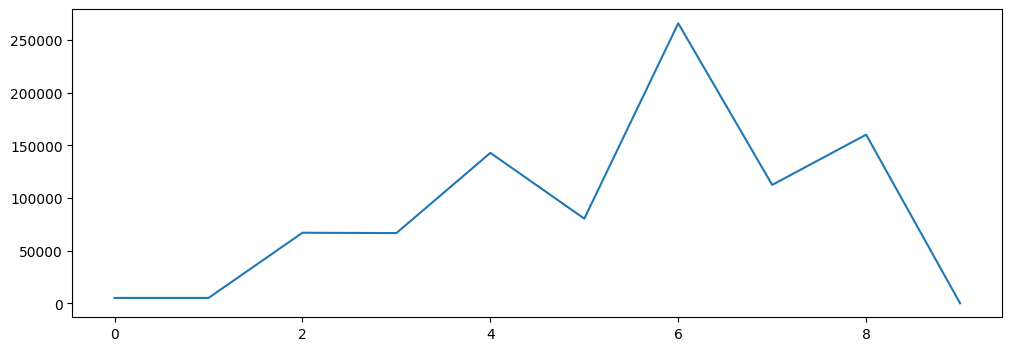

In [238]:
print("uruchamiam test na dixon and price")
result = ESplus()
print("wynik to: ", result)
print("wartość funkcji celu to: ", result.value)

plt.figure(figsize=(12,4))
plt.plot(best_result_values)




# populacja P to:  [29385, 82676, 47898, 78865, 49717, 57841, 18516, 67099, 5132, 102743]
              #    [39264, 82676, 240481, 78865, 199476, 57841, 120401, 67099, 5218, 102743]
# najlepszy osobnik w populacji daje wartość:  5132

# parents to:  [5132 18516 29385 47898 49717]
# najlepszy osobnik w populacji WYBRANYCH RODZICÓW daje wartość:  5132

# childrens to: [5218 120401 39264 240481 199476]
# najlepszy osobnik w populacji POTOMKÓW daje wartość:  5218

# populacja na poczatku  (pattern) =  [39264, 82676, 240481, 78865, 199476, 57841, 120401, 67099, 5218, 102743]

# dastaje P1 =  [5218 120401 39264 240481 199476]
# i P2 =  [39264, 82676, 240481, 78865, 199476, 57841, 120401, 67099, 5218, 102743]
# wybieram =  [5218 5218 39264 39264 57841 67099 78865 82676 102743 120401]
# nowa poplacja to:  [5218 5218 39264 39264 57841 67099 78865 82676 102743 120401]
# najlepszy osobnik w populacji PO REPLACEMENCIE daje wartość:  5218